# PROJET 5 : Segmentez des clients d'un site e-commerce
*Mathieu GENTHON (juin 2020)*

## SOMMAIRE<a class="anchor" id="sommaire"></a>
### 1 - [Contexte du projet](#1)<a class="anchor" id="sommaire"></a>
### 2 - [Importation des librairies et chargement dataframe](#2)<a class="anchor" id="sommaire"></a>
### 3 - [Algorithme de clustering](#3)<a class="anchor" id="sommaire"></a>
#### 3.1 - [Segmentation RFM](#31)<a class="anchor" id="sommaire"></a>
#### 3.2 - [Segmentation RFM (kMeans)](#32)<a class="anchor" id="sommaire"></a>
#### 3.3 - [Segmentation kMeans](#33)<a class="anchor" id="sommaire"></a>
#### 3.4 - [Segmentation DBSCAN](#34)<a class="anchor" id="sommaire"></a>
#### 3.5 - [Segmentation HDBSCAN](#35)<a class="anchor" id="sommaire"></a>

### 1 - [Contexte du projet](#1)<a class="anchor" id="1"></a>

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

Vous devrez fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

Votre mission est d’aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper ensemble des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe marketing pour mieux communiquer.

Pour des raisons de confidentialité, Olist ne fournit pas beaucoup de données, à vous de fouiller dans celles dont vous disposez et de créer les meilleures features pour les exploiter.

Enfin, votre client, Olist, a spécifié sa demande ainsi :

    - La segmentation proposée doit être exploitable et facile d’utilisation pour l’équipe marketing.
    - Vous évaluerez la fréquence à laquelle la segmentation doit être mise à jour, afin de pouvoir effectuer un devis de contrat de maintenance.
    - Le code fourni doit respecter la convention PEP8, pour être utilisable par Olist.

### 2 - [Importation des librairies et chargement dataframe](#2)<a class="anchor" id="2"></a>

In [1]:
# Ligne pour vérifier compatibilité PEP8.
# %load_ext pycodestyle_magic
# %pycodestyle_on
# On importe les librairies dont on devrait avoir besoin pour le projet.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import hdbscan
import plotly.graph_objects as go
from sklearn import preprocessing, cluster, metrics, decomposition
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,adjusted_rand_score
from sklearn.utils.multiclass import unique_labels
from datetime import date, time, datetime
from sklearn.manifold import TSNE
from FunctionsACP import *
%matplotlib inline
sns.set()
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 100

In [2]:
# On charge les données depuis des fichiers en local
path = 'C:/Users/GENTHON-M/Documents/formation/Open Classrooms/\
5-Segmentation clients/'
Customer_Base_T = pd.read_csv(path+"Customer_Base_Export.csv",
                              low_memory=False)
# On transforme au format date pour pouvoir faire des opérations de calcul.
Customer_Base_T['order_purchase_date'] =\
                                        pd.to_datetime(Customer_Base_T[
                                         'order_purchase_date']).dt.date
print(Customer_Base_T.shape)

(93104, 27)


In [3]:
Customer_Base = Customer_Base_T.copy()

### 3 - [Algorithme de clustering](#3)<a class="anchor" id="3"></a>

In [4]:
# Fonction pour dessiner un radar plot des clusters RFM


def radar_plot(Cluster, Color, Name, Cat):
    fig = go.Figure()
    fig.add_trace(go.Scatterpolar(
      r=Cluster,
      theta=Cat,
      fillcolor=Color,
      line=dict(color=Color),
      fill='toself',
      name=Name
      ))
    fig.update_layout(
     polar=dict(
      radialaxis=dict(
       visible=True,
       range=[0, 4]
       )),
     showlegend=True
    )
    fig.show()

# On utilise des quintiles pour la récence et le montant.
# On utilise une discrétisation binaire pour la fréquence
# car plus de 95 % des clients n'ont commandé qu'une seule fois


def r_score(x):
    if x <= quintiles['Recence'][.25]:
        return 4
    elif x <= quintiles['Recence'][.5]:
        return 3
    elif x <= quintiles['Recence'][.75]:
        return 2
    else:
        return 1


def f_score(x):
    if x == 1:
        return 1
    elif x == 2:
        return 2
    elif x == 3:
        return 3
    else:
        return 4


def m_score(x):
    if x <= quintiles['Montant'][.25]:
        return 1
    elif x <= quintiles['Montant'][.5]:
        return 2
    elif x <= quintiles['Montant'][.75]:
        return 3
    else:
        return 4


def Cluster_RFM(x):
    if x >= 9 :
        return 1
    elif (x < 9) & (x >= 6) :
        return 2
    else:
        return 3

#### 3.1 - [Segmentation RFM](#31)<a class="anchor" id="31"></a>

In [5]:
# Utilisé quand test fait sur échantillon pris au hasard.
Customer_Base.reset_index(inplace=True)

In [6]:
rfm = Customer_Base.loc[:, ['customer_unique_id', 'Recence', 'Frequence',
                            'Montant', 'Last_Order_Customer',
                            'Total_Order_Customer',
                            'Total_Amount_Customer']].copy()

In [7]:
quintiles = rfm[['Recence', 'Montant']].quantile([.25, .5, .75]).to_dict()
quintiles

{'Recence': {0.25: 115.0, 0.5: 219.0, 0.75: 346.0},
 'Montant': {0.25: 63.0075, 0.5: 107.78, 0.75: 182.425}}

In [8]:
rfm['R'] = rfm['Recence'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequence'].apply(lambda x: f_score(x))
rfm['M'] = rfm['Montant'].apply(lambda x: m_score(x))
rfm['RFMScore'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm['RFMSum'] = rfm['R'] + rfm['F'] + rfm['M']
rfm['ClusterRFM'] = rfm['RFMSum'].apply(lambda x: Cluster_RFM(x))
rfm

customer_unique_id  Recence  Frequence  Montant  \
0      861eff4711a542e4b93843c6dd7febb0      471          1   146.87   
1      060e732b5b29e8181a18229c7b0b2b5e      103          1   157.73   
2      259dac757896d24d7702b9acbbff3f3c      170          1   173.30   
3      07d190f123147d9e89d4b922543d7948       53          1   315.75   
4      332cf4e83e16004ba7dca932ce82475b      515          1   146.21   
...                                 ...      ...        ...      ...   
93099  38e482d7770a43f5929378c4dec76d5e       14          1  1789.02   
93100  393c2ace23a135d0bcc7e70167448e16       41          1   161.37   
93101  5c22dbb9d8b5385953f2f1e6d9d115a7       29          1    72.18   
93102  7f5f43a9394964ac51bc5d1e0204ead4       12          1   224.44   
93103  82d46759af0369aad49084bacf85a6c3      289          1   199.92   

       Last_Order_Customer  Total_Order_Customer  Total_Amount_Customer  R  F  \
0                      471              0.693147               4.996334  1  1   
1                      103              0.693147               5.067205  4  1   
2                      170              0.693147               5.160778  3  1   
3                       53              0.693147               5.758113  4  1   
4                      515              0.693147               4.991860  1  1   
...                    ...                   ...                    ... .. ..   
93099                   14              0.693147               7.489982  4  1   
93100                   41              0.693147               5.089878  4  1   
93101                   29              0.693147               4.292922  4  1   
93102                   12              0.693147               5.418054  4  1   
93103                  289              0.693147               5.302907  2  1   

       M RFMScore  RFMSum  ClusterRFM  
0      3      113       5           3  
1      3      413       8           2  
2      3      313       7           2  
3      4      414       9           1  
4      3      113       5           3  
...   ..      ...     ...         ...  
93099  4      414       9           1  
93100  3      413       8           2  
93101  2      412       7           2  
93102  4      414       9           1  
93103  4      214       7           2  

[93104 rows x 13 columns]

In [9]:
# Taille des clusters
Cluster_Size = round(rfm.groupby('ClusterRFM')['customer_unique_id']
                     .count()/len(rfm)*100).tolist()

In [10]:
Recence = rfm.groupby('ClusterRFM')['R'].mean().tolist()
Frequence = rfm.groupby('ClusterRFM')['F'].mean().tolist()
Montant = rfm.groupby('ClusterRFM')['M'].mean().tolist()
Cluster0 = []
Cluster1 = []
Cluster2 = []

Cluster0.append(Recence[0])
Cluster0.append(Frequence[0])
Cluster0.append(Montant[0])

Cluster1.append(Recence[1])
Cluster1.append(Frequence[1])
Cluster1.append(Montant[1])

Cluster2.append(Recence[2])
Cluster2.append(Frequence[2])
Cluster2.append(Montant[2])


Categ = ['Recence', 'Frequence', 'Montant']
radar_plot(Cluster0, '#636EFA', 'Cluster 0, Size : '
           + str(Cluster_Size[0])+'%', Categ)
radar_plot(Cluster1, '#00CC96', 'Cluster 1, Size : '
           + str(Cluster_Size[1])+'%', Categ)
radar_plot(Cluster2, '#EF553B', 'Cluster 2, Size : '
           + str(Cluster_Size[2])+'%', Categ)

In [11]:
print("Best Customers: ", len(rfm[rfm['RFMScore'] == '444']))
print("Customers to pamper: ", len(rfm[(rfm['R'] > 3) | (rfm['F'] > 3) |
                                       (rfm['M'] > 3)]))
print('Loyal Customers: ', len(rfm[rfm['F'] == 4]))
print("Big Spenders: ", len(rfm[rfm['M'] == 4]))
print('Almost Lost: ', len(rfm[rfm['R'] == 2]))
print('Lost Customers: ', len(rfm[rfm['R'] == 1]))
print('Lost Cheap Customers: ', len(rfm[rfm['RFMScore'] == '111']))

Best Customers:  22
Customers to pamper:  40794
Loyal Customers:  47
Big Spenders:  23276
Almost Lost:  23297
Lost Customers:  23127
Lost Cheap Customers:  5921


### 3.2 - [Segmentation RFM (kMeans)](#32)<a class="anchor" id="32"></a>

#### 3.2.1 - [Standardisation des données (Centrage - Réduction)](#321)<a class="anchor" id="321"></a>

In [12]:
# Standardisation des variables
features_to_StdScl = ['Last_Order_Customer', 'Total_Order_Customer',
                      'Total_Amount_Customer']
scaler = preprocessing.StandardScaler()
rfm[features_to_StdScl] = scaler.fit_transform(rfm[features_to_StdScl])

In [13]:
rfm_km = rfm.loc[:, ['Last_Order_Customer', 'Total_Order_Customer',
                     'Total_Amount_Customer']].copy()

#### 3.2.2 - [Recherche du meilleur hyper paramètre K](#322)<a class="anchor" id="322"></a>

In [14]:
# On détermine le nombre de cluster idéal avec le coefficient de silhouette.
start_time = timeit.default_timer()
silhouette = []
for i in range(3, 10):
    looptime = timeit.default_timer()
    cls = cluster.KMeans(n_clusters=i, n_init=1, max_iter=300,
                         init='k-means++', n_jobs=-1)
    cls.fit(rfm_km)
    s = metrics.silhouette_score(rfm_km, cls.labels_)
    silhouette.append(s)
    elapsedloop = timeit.default_timer() - looptime
    print("done in %0.3fs" % elapsedloop)
elapsed = timeit.default_timer() - start_time
print("done in %0.3fs" % elapsed)

done in 115.443s
done in 112.619s
done in 112.100s
done in 110.902s
done in 107.525s
done in 105.588s
done in 108.244s
done in 772.426s


Text(0, 0.5, 'coefficient de silhouette')

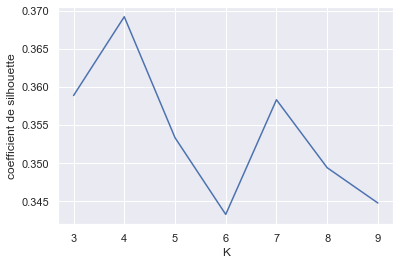

In [15]:
plt.plot(range(3, 10), silhouette)
axes = plt.gca()
axes.set_xlabel('K')
axes.set_ylabel('coefficient de silhouette')

done in 5.439s


Text(0, 0.5, 'SSE')

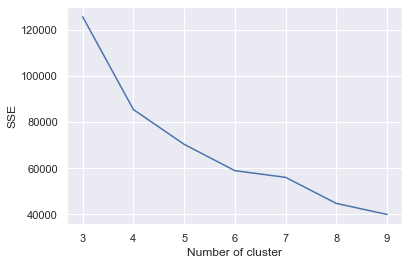

In [16]:
# Méthode du coude
sse = []
start_time = timeit.default_timer()
for i in range(3, 10):
    cls = cluster.KMeans(n_clusters=i, n_init=1,
                         max_iter=300, init='k-means++', n_jobs=-1)
    cls.fit(rfm_km)
    sse.append(cls.inertia_)
elapsed = timeit.default_timer() - start_time
print("done in %0.3fs" % elapsed)

plt.plot(range(3, 10), sse)
plt.xlabel("Number of cluster")
plt.ylabel("SSE")

In [14]:
cls_rfm_km = cluster.KMeans(n_clusters=4)
cls_rfm_km.fit(rfm_km)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

#### 3.2.3 - [Visualisation par ACP](#323)<a class="anchor" id="323"></a>

[0.38923443 0.72146992 1.        ]


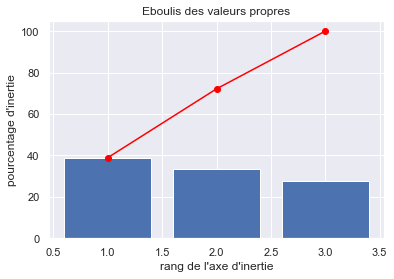

In [15]:
pca_rfm = decomposition.PCA()
pca_rfm.fit(rfm_km)
print(pca_rfm.explained_variance_ratio_.cumsum())
X_trans = pca_rfm.transform(rfm_km)
display_scree_plot(pca_rfm)

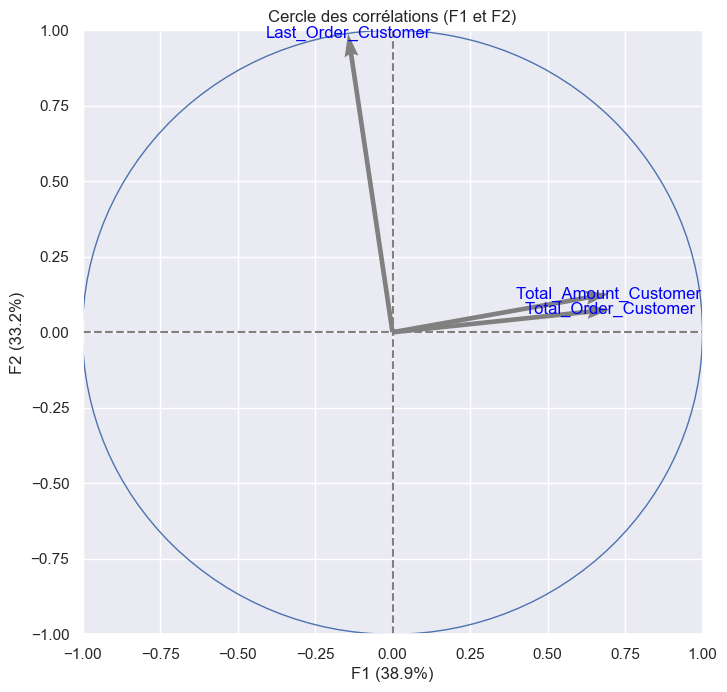

In [16]:
# Cercle des corrélations
pcs = pca_rfm.components_
display_circles(pcs, 2, pca_rfm, [(0, 1)], labels=np.array(features_to_StdScl))

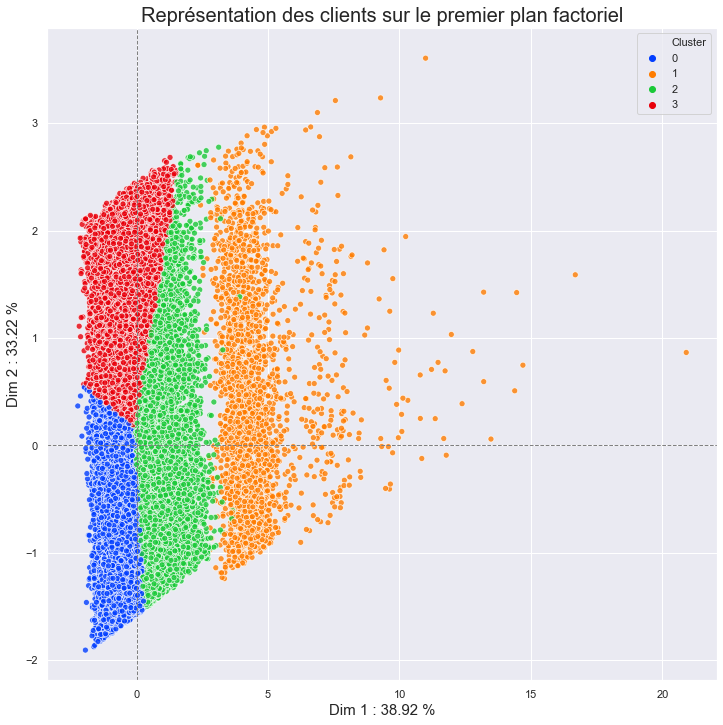

In [17]:
# Transformation en DataFrame pandas
df_PCA = pd.DataFrame({
    "Dim1" : X_trans[:, 0], 
    "Dim2" : X_trans[:, 1],
    "Cluster" : cls_rfm_km.labels_
})

fig = plt.figure(figsize=(12, 12))
g_pca = sns.scatterplot(x="Dim1", y="Dim2", data = df_PCA,
                        hue = "Cluster", palette='bright', alpha=0.8)
plt.title("Représentation des clients sur le premier plan factoriel", size=20)
g_pca.set_xlabel("Dim 1 : " + str(round(pca_rfm.explained_variance_ratio_[0]
                                        * 100,2)) + " %", fontsize=15)
g_pca.set_ylabel("Dim 2 : " + str(round(pca_rfm.explained_variance_ratio_[1]
                                        * 100,2)) + " %", fontsize=15)
plt.axvline(color='gray', linestyle='--', linewidth=1)
plt.axhline(color='gray', linestyle='--', linewidth=1)

#### 3.2.4 - [Visualisation par radar chart](#324)<a class="anchor" id="324"></a>

In [18]:
rfm['Cluster_RFM_km'] = pd.Series(cls_rfm_km.labels_)

Récence = rfm.groupby('Cluster_RFM_km')['R'].mean()
Fréquence = rfm.groupby('Cluster_RFM_km')['F'].mean()
Montant = rfm.groupby('Cluster_RFM_km')['M'].mean()
Cluster0 = []
Cluster1 = []
Cluster2 = []
Cluster3 = []

Cluster0.append(Récence[0])
Cluster0.append(Fréquence[0])
Cluster0.append(Montant[0])

Cluster1.append(Récence[1])
Cluster1.append(Fréquence[1])
Cluster1.append(Montant[1])

Cluster2.append(Récence[2])
Cluster2.append(Fréquence[2])
Cluster2.append(Montant[2])

Cluster3.append(Récence[3])
Cluster3.append(Fréquence[3])
Cluster3.append(Montant[3])

In [19]:
# Taille des clusters
Cluster_Size_rfm_km = round(rfm.groupby('Cluster_RFM_km')['customer_unique_id']
                            .count()/len(rfm)*100).tolist()

In [20]:
Categ = ['Recence', 'Frequence', 'Montant']
radar_plot(Cluster0, '#636EFA', 'Cluster 0, Size : '
           + str(Cluster_Size_rfm_km[0])+'%', Categ)
radar_plot(Cluster1, '#00CC96', 'Cluster 1, Size : '
           + str(Cluster_Size_rfm_km[1])+'%', Categ)
radar_plot(Cluster2, '#FFA15A', 'Cluster 2, Size : '
           + str(Cluster_Size_rfm_km[2])+'%', Categ)

In [21]:
radar_plot(Cluster3, '#EF553B', 'Cluster 3, Size : '
           + str(Cluster_Size_rfm_km[3])+'%', Categ)

#### 3.3 - [Segmentation kMeans](#33)<a class="anchor" id="33"></a>

##### 3.3.1 - [Normalisation des données (Centrage - Réduction)](#331)<a class="anchor" id="331"></a>

In [22]:
var_scl = ['Item_Quantity_Customer', 'Review_Score_Mean_Customer',
           'Total_Amount_Customer', 'Total_Order_Customer',
           'Last_Order_Customer',
           'Product_Photo_Nb_Mean_Customer',
           'Product_Desc_Length_Mean_Customer',
           'Order_Paiement_Nb_Mean_Customer',
           'boleto_Total_Customer', 'credit_card_Total_Customer',
           'debit_card_Total_Customer', 'voucher_Total_Customer',
           'construction_Total_Customer', 'electronics_Total_Customer',
           'fashion_Total_Customer', 'food_Total_Customer',
           'home_Total_Customer',
           'leisure_Total_Customer', 'misc_Total_Customer']

k_means_var_other = ['customer_unique_id', 'State_Customer',
                     'order_purchase_date']

df_scaled = Customer_Base.loc[:, k_means_var_other+var_scl].copy()

scaler = preprocessing.StandardScaler()
df_scaled[var_scl] = scaler.fit_transform(df_scaled[var_scl])
df_scaled

customer_unique_id  State_Customer order_purchase_date  \
0      861eff4711a542e4b93843c6dd7febb0              25          2017-05-16   
1      060e732b5b29e8181a18229c7b0b2b5e              25          2018-05-19   
2      259dac757896d24d7702b9acbbff3f3c              25          2018-03-13   
3      07d190f123147d9e89d4b922543d7948              25          2018-07-08   
4      332cf4e83e16004ba7dca932ce82475b              25          2017-04-02   
...                                 ...             ...                 ...   
93099  38e482d7770a43f5929378c4dec76d5e              25          2018-08-16   
93100  393c2ace23a135d0bcc7e70167448e16              25          2018-07-20   
93101  5c22dbb9d8b5385953f2f1e6d9d115a7               5          2018-08-01   
93102  7f5f43a9394964ac51bc5d1e0204ead4              22          2018-08-18   
93103  82d46759af0369aad49084bacf85a6c3              25          2017-11-14   

       Item_Quantity_Customer  Review_Score_Mean_Customer  \
0                   -0.341088                    0.690389   
1                   -0.341088                   -0.051373   
2                   -0.341088                    0.690389   
3                   -0.341088                    0.690389   
4                   -0.341088                    0.690389   
...                       ...                         ...   
93099               -0.341088                   -0.051373   
93100               -0.341088                   -1.534897   
93101               -0.341088                    0.690389   
93102               -0.341088                   -0.051373   
93103               -0.341088                    0.690389   

       Total_Amount_Customer  Total_Order_Customer  Last_Order_Customer  \
0                   0.331167             -0.170042             1.548641   
1                   0.418850             -0.170042            -0.889330   
2                   0.534621             -0.170042            -0.445460   
3                   1.273654             -0.170042            -1.220576   
4                   0.325633             -0.170042             1.840137   
...                      ...                   ...                  ...   
93099               3.416354             -0.170042            -1.478948   
93100               0.446902             -0.170042            -1.300075   
93101              -0.539106             -0.170042            -1.379574   
93102               0.852927             -0.170042            -1.492197   
93103               0.710465             -0.170042             0.342905   

       Product_Photo_Nb_Mean_Customer  Product_Desc_Length_Mean_Customer  \
0                           -0.700047                           0.686800   
1                           -0.700047                           0.521306   
2                           -0.700047                           0.623564   
3                           -0.700047                           0.676142   
4                           -0.700047                          -1.172316   
...                               ...                                ...   
93099                       -0.700047                           0.262546   
93100                       -0.700047                           1.150846   
93101                       -0.700047                          -0.213841   
93102                        3.304022                           0.396444   
93103                       -0.700047                          -1.995739   

       Order_Paiement_Nb_Mean_Customer  boleto_Total_Customer  \
0                            -0.155988              -0.491733   
1                            -0.155988              -0.491733   
2                            -0.155988              -0.491733   
3                            -0.155988              -0.491733   
4                            -0.155988               2.158856   
...                                ...                    ...   
93099                        -0.155988              -0.491733   
93100

##### 3.3.2 - [Réduction de dimension par ACP](#332)<a class="anchor" id="332"></a>

In [23]:
# On retire 'Total_Amount_Customer' car corrélé à Credit Card Total Customer
var_km = ['Item_Quantity_Customer', 'Review_Score_Mean_Customer',
          'Total_Order_Customer', 'Last_Order_Customer',
          'Product_Photo_Nb_Mean_Customer',
          'Product_Desc_Length_Mean_Customer',
          'Order_Paiement_Nb_Mean_Customer',
          'boleto_Total_Customer', 'credit_card_Total_Customer',
          'debit_card_Total_Customer', 'voucher_Total_Customer',
          'construction_Total_Customer', 'electronics_Total_Customer',
          'fashion_Total_Customer', 'food_Total_Customer',
          'home_Total_Customer', 'leisure_Total_Customer',
          'misc_Total_Customer'
          ]
X_KMeans = df_scaled.loc[:, var_km].copy()

[0.10381384 0.20021098 0.28639212 0.36434266 0.43557585 0.50236823
 0.56742415 0.62922384 0.68852632 0.74566467 0.80155402 0.85708248
 0.90807902 0.94718126 0.97657036 0.99354137 0.99937224 1.        ]


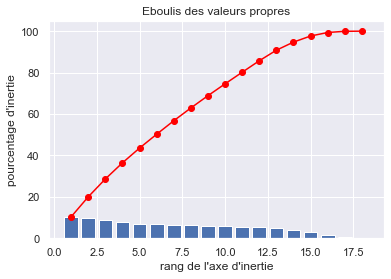

In [24]:
pca_km = decomposition.PCA()
pca_km.fit(X_KMeans)
print(pca_km.explained_variance_ratio_.cumsum())
X_ACP = pd.DataFrame(pca_km.transform(X_KMeans))
display_scree_plot(pca_km)

In [37]:
# On garde les 15 premières composantes pour expliquer plus 95 % de la variance.
X_ACP_km_run = X_ACP.iloc[:, range(0, 14)].copy()

##### 3.3.3 - [Recherche du meilleur hyper paramètre K](#333)<a class="anchor" id="333"></a>

In [67]:
start_time = timeit.default_timer()

silhouette = []
for i in range(3, 10):
    looptime = timeit.default_timer()
    cls = cluster.KMeans(n_clusters=i, n_init=1, max_iter=300,
                         init='k-means++', n_jobs=-1)
    cls.fit(X_ACP_km_run)
    s = metrics.silhouette_score(X_ACP_km_run, cls.labels_)
    silhouette.append(s)
    elapsedloop = timeit.default_timer() - looptime
    print("done in %0.3fs" % elapsedloop)
elapsed = timeit.default_timer() - start_time
print("done in %0.3fs" % elapsed)

done in 119.114s
done in 117.568s
done in 114.774s
done in 118.626s
done in 111.290s
done in 111.350s
done in 111.013s
done in 803.739s


Text(0, 0.5, 'coefficient de silhouette')

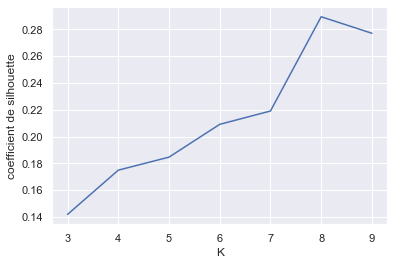

In [68]:
plt.plot(range(3, 10), silhouette)
axes = plt.gca()
axes.set_xlabel('K')
axes.set_ylabel('coefficient de silhouette')

done in 4.394s


Text(0, 0.5, 'SSE')

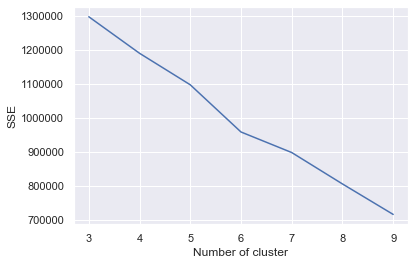

In [64]:
# Méthode du coude
sse = []
start_time = timeit.default_timer()
for i in range(3, 10):
    cls = cluster.KMeans(n_clusters=i, n_init=1, max_iter=300,
                         init='k-means++', n_jobs=-1)
    cls.fit(X_ACP_km_run)
    sse.append(cls.inertia_)
elapsed = timeit.default_timer() - start_time
print("done in %0.3fs" % elapsed)

plt.plot(range(3, 10), sse)
plt.xlabel("Number of cluster")
plt.ylabel("SSE")

In [38]:
cls_km = cluster.KMeans(n_clusters=8)
cls_km.fit(X_ACP_km_run)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [39]:
X_ACP_km_run['Cluster_km'] = pd.Series(cls_km.labels_)
X_ACP_km_run['customer_unique_id'] = df_scaled['customer_unique_id']
# Taille des clusters
Cluster_Size_km = round(X_ACP_km_run.groupby('Cluster_km')
                        ['customer_unique_id']
                        .count()/len(rfm)*100).tolist()
Cluster_Size_km

[5.0, 27.0, 14.0, 3.0, 15.0, 15.0, 17.0, 2.0]

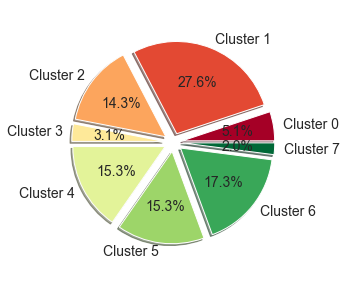

In [40]:
cluster_km_cat = ['Cluster 0', 'Cluster 1', 'Cluster 2',
                  'Cluster 3', 'Cluster 4',
                  'Cluster 5', 'Cluster 6', 'Cluster 7']

sep = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)

category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0, 1, len(Cluster_Size_km)))


fig, ax = plt.subplots(figsize=(4, 5))
ax.pie(Cluster_Size_km, explode=sep, labels=cluster_km_cat, autopct='%1.1f%%',
       shadow=True, colors=category_colors, textprops={'fontsize': 14})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

##### 3.3.4 - [Représentation graphique](#334)<a class="anchor" id="334"></a>

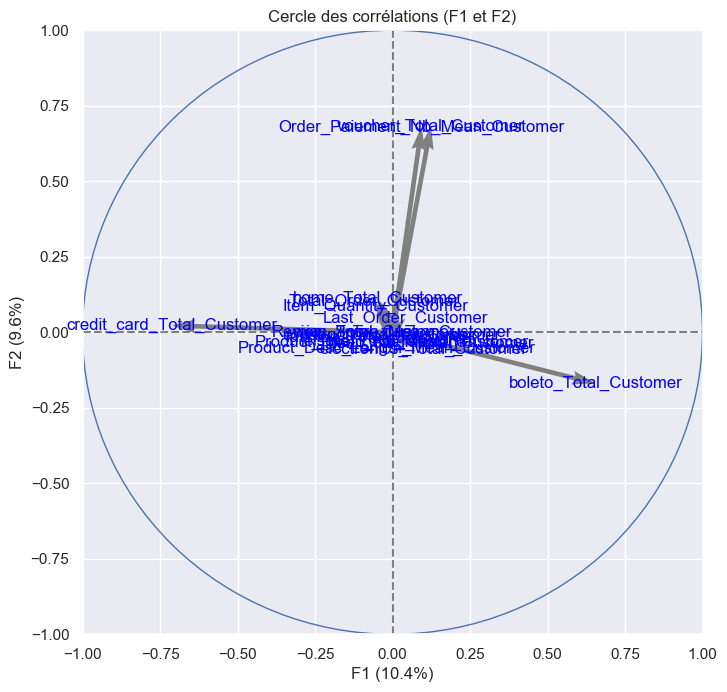

In [41]:
# Cercle des corrélations
pcs = pca_km.components_
display_circles(pcs, 2, pca_km, [(0, 1)], labels=np.array(var_km))

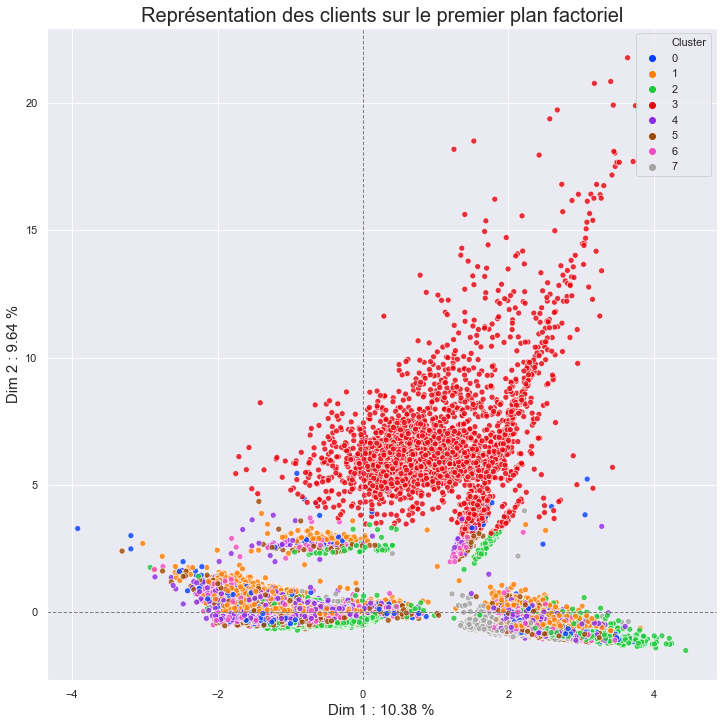

In [42]:
# Transformation en DataFrame pandas
df_PCA_km = pd.DataFrame({
    "Dim1" : X_ACP_km_run.iloc[:, 0], 
    "Dim2" : X_ACP_km_run.iloc[:, 1],
    "Cluster" : cls_km.labels_
})

fig = plt.figure(figsize=(12, 12))
g_pca = sns.scatterplot(x="Dim1", y="Dim2", data = df_PCA_km, 
                        hue = "Cluster", palette='bright', alpha=0.8)
plt.title("Représentation des clients sur le premier plan factoriel", size=20)
g_pca.set_xlabel("Dim 1 : " + str(round(pca_km.explained_variance_ratio_[0]
                                        * 100,2)) + " %", fontsize=15)
g_pca.set_ylabel("Dim 2 : " + str(round(pca_km.explained_variance_ratio_[1]
                                        * 100,2)) + " %", fontsize=15)
plt.axvline(color='gray', linestyle='--', linewidth=1)
plt.axhline(color='gray', linestyle='--', linewidth=1)

In [43]:
X_tsne_km = X_ACP_km_run.drop(['Cluster_km', 'customer_unique_id'],
                              axis=1)

In [44]:
tsne_km_acp = TSNE(n_jobs=-1, perplexity=100)
X_tsne_km_acp = tsne_km_acp.fit_transform(X_tsne_km)

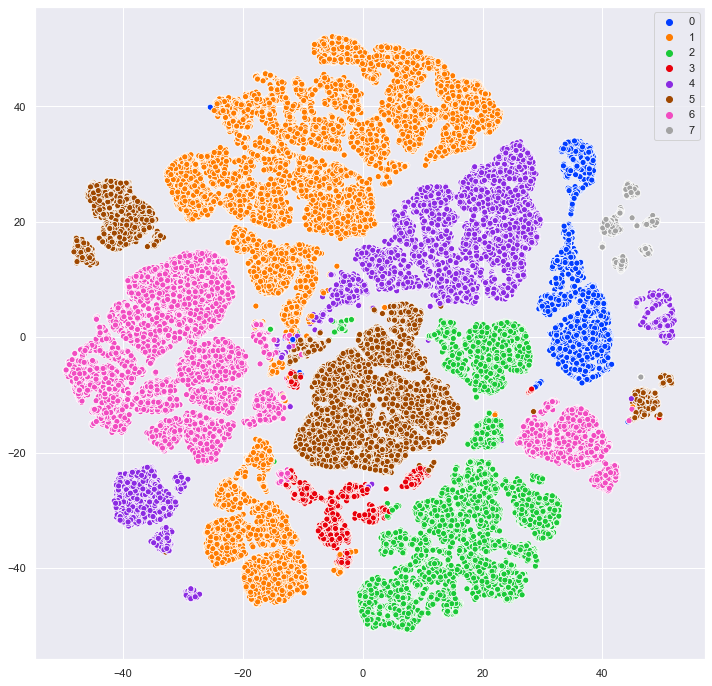

In [45]:
fig = plt.figure(figsize=(12, 12))
pal = sns.color_palette("bright", 8)
sns.scatterplot(X_tsne_km_acp[:, 0], X_tsne_km_acp[:, 1],
                hue=cls_km.labels_, legend='full', palette=pal)

##### 3.3.5 - [Caractéristique des différents clusters - Création de personna](#335)<a class="anchor" id="335"></a>

In [46]:
Customer_Base['Cluster_km'] = pd.Series(cls_km.labels_)
Customer_Base

index                customer_unique_id  State_Customer  \
0          0  861eff4711a542e4b93843c6dd7febb0              25   
1          1  060e732b5b29e8181a18229c7b0b2b5e              25   
2          2  259dac757896d24d7702b9acbbff3f3c              25   
3          3  07d190f123147d9e89d4b922543d7948              25   
4          4  332cf4e83e16004ba7dca932ce82475b              25   
...      ...                               ...             ...   
93099  93099  38e482d7770a43f5929378c4dec76d5e              25   
93100  93100  393c2ace23a135d0bcc7e70167448e16              25   
93101  93101  5c22dbb9d8b5385953f2f1e6d9d115a7               5   
93102  93102  7f5f43a9394964ac51bc5d1e0204ead4              22   
93103  93103  82d46759af0369aad49084bacf85a6c3              25   

      order_purchase_date  Last_Order_Customer  Review_Score_Mean_Customer  \
0              2017-05-16                  471                         5.0   
1              2018-05-19                  103                         4.0   
2              2018-03-13                  170                         5.0   
3              2018-07-08                   53                         5.0   
4              2017-04-02                  515                         5.0   
...                   ...                  ...                         ...   
93099          2018-08-16                   14                         4.0   
93100          2018-07-20                   41                         2.0   
93101          2018-08-01                   29                         5.0   
93102          2018-08-18                   12                         4.0   
93103          2017-11-14                  289                         5.0   

       Product_Photo_Nb_Mean_Customer  Delivery_Accuracy_Mean_Customer  \
0                                 1.0                            -11.0   
1                                 1.0                              1.0   
2                                 1.0                            -13.0   
3                                 1.0                             -8.0   
4                                 1.0                             -6.0   
...                               ...                              ...   
93099                             1.0                            -27.0   
93100                             1.0                            -18.0   
93101                             1.0                            -14.0   
93102                             8.0                            -13.0   
93103                             1.0                              7.0   

       Delivery_Time_Mean_Customer  Total_Amount_Customer  \
0                              8.0               4.996334   
1                             26.0               5.067205   
2                             14.0               5.160778   
3                             31.0               5.758113   
4                             29.0               4.991860   
...                            ...                    ...   
93099                         12.0               7.489982   
93100                          7.0               5.089878   
93101                         12.0               4.292922   
93102                          9.0               5.418054   
93103                         35.0               5.302907   

       Item_Quantity_Customer  Total_Order_Customer  \
0                    0.693147              0.693147   
1                    0.693147              0.693147   
2                    0.693147              0.693147   
3                    0.693147              0.693147   
4                    0.693147              0.693147   
...                       ...                   ...   
93099                0.693147              0.693147   
93100                0.693147              0.693147   
93101                0.693147              0.693147   
93102                0.693147              0.693147   
93103                0.693147              0.69314

In [47]:
VarToExp = ['Total_Amount_Customer', 'Item_Quantity_Customer',
            'Total_Order_Customer',
            'Order_Paiement_Nb_Mean_Customer',
            'Product_Desc_Length_Mean_Customer',
            'boleto_Total_Customer', 'credit_card_Total_Customer',
            'debit_card_Total_Customer', 'voucher_Total_Customer',
            'construction_Total_Customer', 'electronics_Total_Customer',
            'fashion_Total_Customer', 'food_Total_Customer',
            'home_Total_Customer',
            'leisure_Total_Customer', 'misc_Total_Customer']

Customer_Base_Exp = Customer_Base.copy()
Customer_Base_Exp.loc[:, VarToExp] = np.expm1(
                                     Customer_Base_Exp.loc[:, VarToExp])

In [48]:
def cluster_rep(results, category_names):

    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0, 1, data.shape[1]))

    Max_value = max([sublist[-1] for sublist in data_cum])
    Max_serie = []
    for j, clu in enumerate(results):
        Max_serie.append(max([num for num in data_cum[j, :]]))

    fig, ax = plt.subplots(figsize=(12, 6), sharex=True)

    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):

        widths = data[:, i]
        widths_1 = widths*Max_value
        width_scaled = [k / l for k, l in zip(widths_1, Max_serie)]

        starts = data_cum[:, i]
        starts1 = starts*Max_value
        starts2 = [m / n for m, n in zip(starts1, Max_serie)]
        starts_scaled = [o - p for o, p in zip(starts2, width_scaled)]
        ax.barh(labels, width_scaled, left=starts_scaled, height=0.5,
                label=colname, color=color)
        xcenters = [o + p/2 for o, p in zip(starts_scaled, width_scaled)]

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'

        for y, (x, c) in enumerate(zip(xcenters, widths)):

            ax.text(x, y, str(int(c)), ha='center', va='center',
                    color=text_color)

        ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
                  loc='lower left', fontsize='small')

    return fig, ax

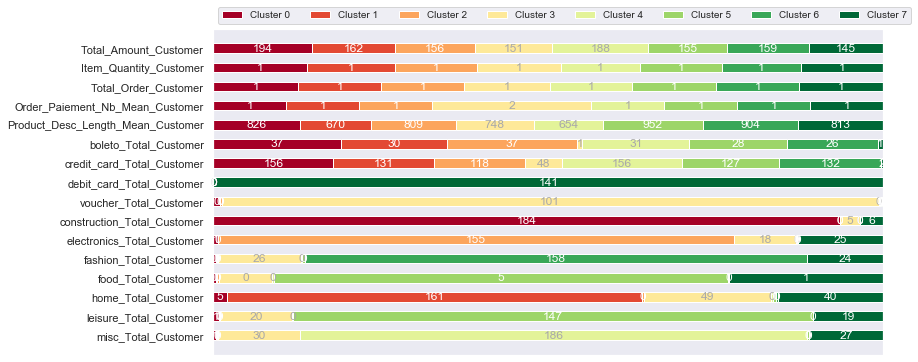

In [49]:
Persona_dict = {}
for var in VarToExp:
    Persona_dict[var] = Customer_Base_Exp.groupby('Cluster_km')[var]\
                        .mean().tolist()

cluster_rep(Persona_dict, cluster_km_cat)
plt.show()

#### 3.4 - [Segmentation kMeans (sans ACP)](#34)<a class="anchor" id="34"></a>

In [44]:
start_time = timeit.default_timer()

silhouette = []
for i in range(3, 10):
    looptime = timeit.default_timer()
    cls = cluster.KMeans(n_clusters=i, n_init=1,
                         max_iter=300, init='k-means++', n_jobs=-1)
    cls.fit(X_KMeans)
    s = metrics.silhouette_score(X_KMeans, cls.labels_)
    silhouette.append(s)
    elapsedloop = timeit.default_timer() - looptime
    print("done in %0.3fs" % elapsedloop)
elapsed = timeit.default_timer() - start_time
print("done in %0.3fs" % elapsed)

done in 122.939s
done in 122.814s
done in 123.197s
done in 128.161s
done in 115.817s
done in 127.647s
done in 125.225s
done in 865.806s


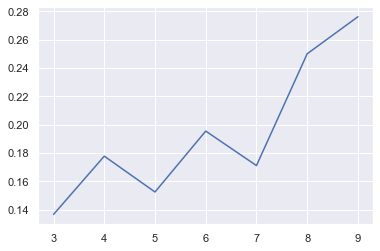

In [45]:
plt.plot(range(3, 10), silhouette)

done in 6.471s


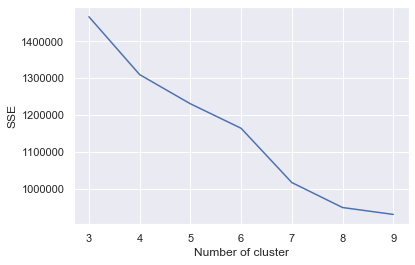

In [46]:
# Méthode du coude
sse = []
start_time = timeit.default_timer()
for i in range(3, 10):
    cls = cluster.KMeans(n_clusters=i, n_init=1,
                         max_iter=300, init='k-means++', n_jobs=-1)
    cls.fit(X_KMeans)
    sse.append(cls.inertia_)

plt.plot(range(3, 10), sse)
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
elapsed = timeit.default_timer() - start_time
print("done in %0.3fs" % elapsed)

In [47]:
cls = cluster.KMeans(n_clusters=9, n_init=1,
                     max_iter=200, init='k-means++')
cls.fit(X_KMeans)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=200,
       n_clusters=9, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [48]:
tsne = TSNE(n_jobs=-1, perplexity=100, init='pca')
X_embedded = tsne.fit_transform(X_KMeans)

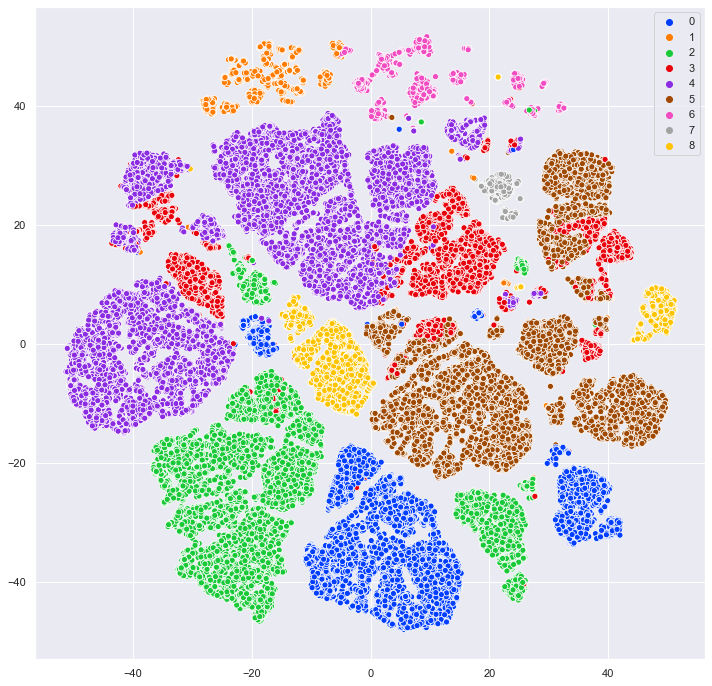

In [49]:
fig = plt.figure(figsize=(12, 12))
palette = sns.color_palette("bright", 9)
sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1],
                hue=cls.labels_, legend='full', palette=palette)

#### 3.5 - [Segmentation DBScan](#35)<a class="anchor" id="35"></a>

In [50]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [51]:
# On garde les 10 premières composantes pour expliquer 80 % de la variance.
# On prend un échantillon de 50 % car problème de mémoire avec certains paramètre de DBSCAN
X_ACP_DB_run = X_ACP.iloc[:, range(0,
                          11)].copy()

X_ACP_DB_run_fr = X_ACP_DB_run.sample(frac=0.5, random_state=1)

In [52]:
db = DBSCAN(eps=2, min_samples=100)
db.fit(X_ACP_DB_run_fr)

DBSCAN(algorithm='auto', eps=2, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=100, n_jobs=None, p=None)

In [56]:
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)


print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_ACP_DB_run_fr, labels))

Estimated number of clusters: 13
Estimated number of noise points: 2205
Silhouette Coefficient: 0.216


In [57]:
tsne_DBS = TSNE(n_jobs=-1, perplexity=50, init='pca')
X_tsne_DBS = tsne_DBS.fit_transform(X_ACP_DB_run_fr)

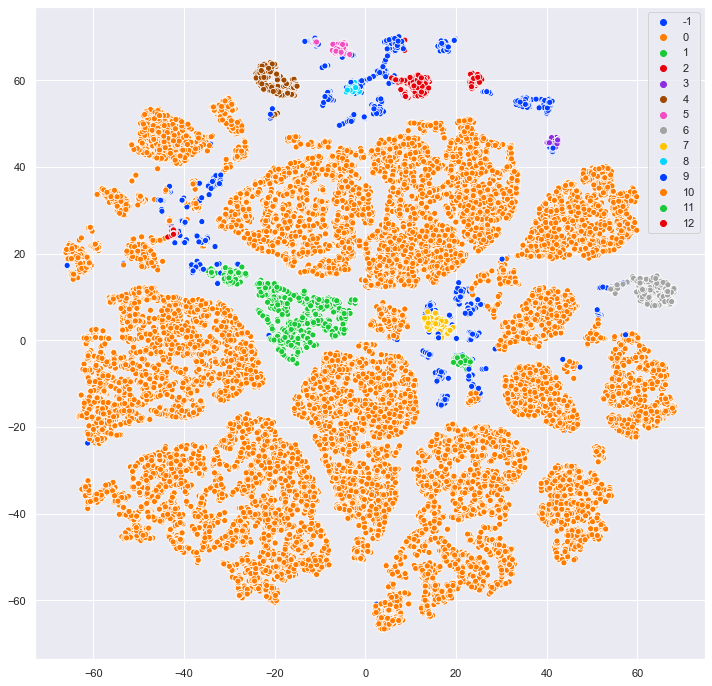

In [58]:
fig = plt.figure(figsize=(12, 12))
palette = sns.color_palette("bright", 14)
sns.scatterplot(X_tsne_DBS[:,0], X_tsne_DBS[:,1],
                hue=db.labels_, legend='full', palette=palette)

#### 3.6 - [Segmentation HDBScan](#36)<a class="anchor" id="36"></a>

In [59]:
# On garde les 11 premières composantes pour expliquer 80 % de la variance.
X_ACP_HDB_run = X_ACP.iloc[:, range(0, 11)].copy()

In [60]:
hdb = hdbscan.HDBSCAN(min_cluster_size=3000, min_samples=1)
hdb.fit(X_ACP_HDB_run)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=3000, min_samples=1, p=None,
        prediction_data=False)

In [61]:
labels = hdb.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_tsne_km, labels))

Estimated number of clusters: 11
Estimated number of noise points: 13845
Silhouette Coefficient: 0.170


In [62]:
tsne_HDBS = TSNE(n_jobs=-1, perplexity=50, init='pca')
X_tsne_HDBS = tsne_HDBS.fit_transform(X_ACP_DB_run)

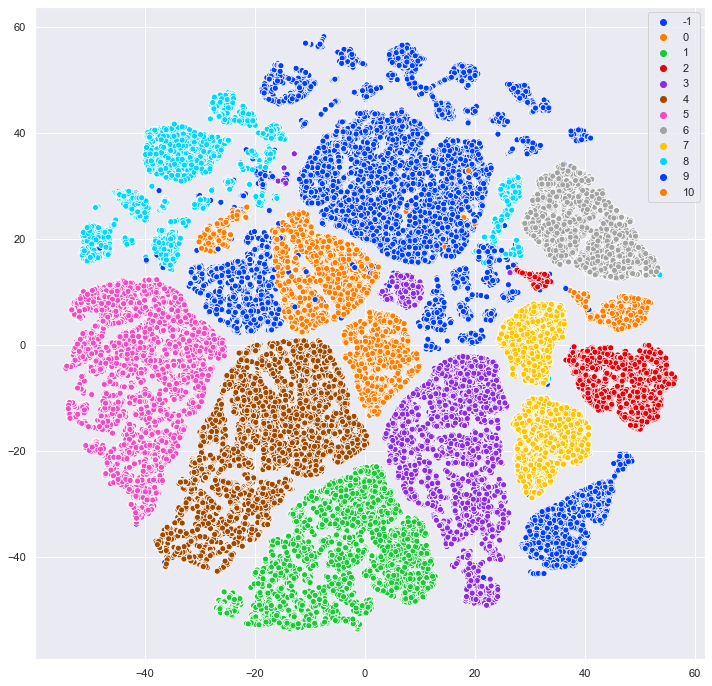

In [63]:
fig = plt.figure(figsize=(12, 12))
palette = sns.color_palette("bright", 12)
sns.scatterplot(X_tsne_HDBS[:, 0], X_tsne_HDBS[:, 1],
                hue=hdb.labels_, legend='full', palette=palette)

In [66]:
X_ACP_HDB_run['Cluster_HDB'] = pd.Series(hdb.labels_)
X_ACP_HDB_run['customer_unique_id'] = df_scaled['customer_unique_id']
# Taille des clusters
Cluster_Size_hdbs = round(X_ACP_HDB_run.groupby('Cluster_HDB')
                          ['customer_unique_id']
                          .count()/len(rfm)*100).tolist()
Cluster_Size_hdbs

[15.0, 5.0, 10.0, 4.0, 11.0, 13.0, 10.0, 5.0, 6.0, 8.0, 10.0, 5.0]

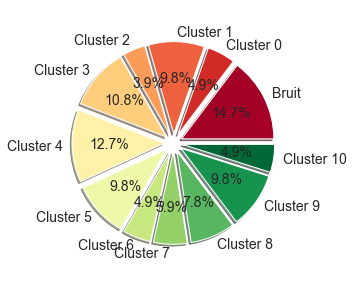

In [67]:
cluster_hdbs_cat = ['Bruit', 'Cluster 0', 'Cluster 1', 'Cluster 2',
                    'Cluster 3', 'Cluster 4',
                    'Cluster 5', 'Cluster 6', 'Cluster 7',
                    'Cluster 8', 'Cluster 9', 'Cluster 10']

sep = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1)

category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0, 1, len(Cluster_Size_hdbs)))


fig, ax = plt.subplots(figsize=(4, 5))
ax.pie(Cluster_Size_hdbs, explode=sep,
       labels=cluster_hdbs_cat, autopct='%1.1f%%',
       shadow=True, colors=category_colors, textprops={'fontsize': 14})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

### 4 - [Stabilité dans le temps de la segmentation](#4)<a class="anchor" id="4"></a>

#### 4.1 - [Préparation des données](#41)<a class="anchor" id="41"></a>

In [90]:
'''
Standardisation des données (centrage réduction)
'''
var_other = ['customer_unique_id', 'State_Customer', 'order_purchase_date']

Customer_Base_T_ID = df_scaled.loc[:, var_other].copy()
Customer_Base_T_scaled = df_scaled.loc[:, var_km].copy()

[0.1  0.2  0.29 0.36 0.44 0.5  0.57 0.63 0.69 0.75 0.8  0.86 0.91 0.95
 0.98 0.99 1.   1.  ]


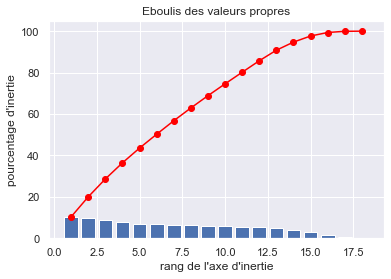

In [91]:
# ACP pour améliorer l'efficacité du KMeans.
pca_km_st = decomposition.PCA()
pca_km_st.fit(Customer_Base_T_scaled)
print(pca_km_st.explained_variance_ratio_.cumsum())
Customer_Base_T_pca = pd.DataFrame(pca_km_st.transform(Customer_Base_T_scaled))
display_scree_plot(pca_km_st)

In [92]:
# On garde les 14 premières composantes pour expliquer 95 % de la variance.
Customer_Base_T_pca14 = Customer_Base_T_pca.iloc[:, range(0, 14)].copy()
Customer_Base_T_ST = pd.merge(Customer_Base_T_pca14, Customer_Base_T_ID,
                              left_index=True, right_index=True)
Customer_Base_T_ST

0         1         2         3         4         5         6  \
0     -0.813104  0.101001  0.552026 -0.500851 -2.063975  0.054818 -0.015467   
1     -0.935620  0.002661  0.560783 -0.438520 -1.483004 -0.234487  0.241466   
2     -0.953501  0.024046  0.577506 -0.418820 -1.639526 -0.173501  0.199571   
3     -1.199673  0.022515  0.679106 -0.387971 -1.639071 -0.252411  0.295271   
4      2.642494 -0.291649  1.119225 -1.627071 -1.795279 -0.080425 -0.600727   
...         ...       ...       ...       ...       ...       ...       ...   
93099 -1.859156 -0.303515 -0.972803  1.212396  0.523063 -3.207094 -0.693318   
93100  2.694845 -0.935058  0.325263  1.517205  0.912451 -0.820683  0.529817   
93101 -0.711876 -0.245231 -0.537846 -1.465732  1.485437 -0.040981 -0.076173   
93102 -0.998985 -0.452340 -0.729830  1.676426  0.848541  1.043393  0.074959   
93103 -0.090673  2.612644 -0.850392 -0.903499  0.473316  0.190299  2.827567   

              7         8         9        10        11        12        13  \
0     -0.393566 -0.114749  0.019556  0.148146 -0.625238  0.777843 -1.166034   
1      0.869148  0.392600  0.106558  0.098674  0.091696 -1.009978 -0.508669   
2      0.645413  0.329198  0.148542  0.156222 -0.639947 -0.688198 -0.684792   
3      1.110288  0.497368  0.263620  0.167057 -0.639256 -1.272475 -0.562054   
4     -0.963653 -0.396831 -0.176548  0.264068 -0.631730  0.769052  0.026887   
...         ...       ...       ...       ...       ...       ...       ...   
93099 -0.263015  0.328664 -0.175765 -0.135276  0.013528 -1.219529  0.293720   
93100  3.285120  4.089492 -2.281310  9.803008  2.208157  2.310891  0.406111   
93101  0.703603  0.406995  0.276148  0.239081 -0.684882 -1.049895 -0.721116   
93102  3.741292 -3.377252 -0.931074 -0.497164 -0.345755  0.396464  1.740133   
93103 -1.670904  0.073095 -0.601849 -0.057712 -0.685784 -0.039071  1.245726   

                     customer_unique_id  State_Customer order_purchase_date  
0      861eff4711a542e4b93843c6dd7febb0              25          2017-05-16  
1      060e732b5b29e8181a18229c7b0b2b5e              25          2018-05-19  
2      259dac757896d24d7702b9acbbff3f3c              25          2018-03-13  
3      07d190f123147d9e89d4b922543d7948              25          2018-07-08  
4      332cf4e83e16004ba7dca932ce82475b              25          2017-04-02  
...                                 ...             ...                 ...  
93099  38e482d7770a43f5929378c4dec76d5e              25          2018-08-16  
93100  393c2ace23a135d0bcc7e70167448e16              25          2018-07-20  
93101  5c22dbb9d8b5385953f2f1e6d9d115a7               5          2018-08-01  
93102  7f5f43a9394964ac51bc5d1e0204ead4              22          2018-08-18  
93103  82d46759af0369aad49084bacf85a6c3              25          2017-11-14  

[93104 rows x 17 columns]

In [93]:
# On fixe la période de référence (année 2017)
Ref_Period = (Customer_Base_T_ST["order_purchase_date"] > date(2016, 12, 31))\
              & (Customer_Base_T_ST["order_purchase_date"] < date(2018, 1, 1))
df_ref = Customer_Base_T_ST[Ref_Period]
# On fixe les périodes glissantes
M0_Period = (Customer_Base_T_ST["order_purchase_date"] > date(2016, 12, 31))\
            & (Customer_Base_T_ST["order_purchase_date"] < date(2018, 1, 1))
df_M0 = Customer_Base_T_ST[M0_Period]

M1_Period = (Customer_Base_T_ST["order_purchase_date"] > date(2017, 1, 31)) & \
                 (Customer_Base_T_ST["order_purchase_date"] < date(2018, 2, 1))
df_M1 = Customer_Base_T_ST[M1_Period]

M2_Period = (Customer_Base_T_ST["order_purchase_date"] > date(2017, 2, 28)) & \
                 (Customer_Base_T_ST["order_purchase_date"] < date(2018, 3, 1))
df_M2 = Customer_Base_T_ST[M2_Period]

M3_Period = (Customer_Base_T_ST["order_purchase_date"] > date(2017, 3, 31)) & \
                 (Customer_Base_T_ST["order_purchase_date"] < date(2018, 4, 1))
df_M3 = Customer_Base_T_ST[M3_Period]

M4_Period = (Customer_Base_T_ST["order_purchase_date"] > date(2017, 4, 30)) & \
                 (Customer_Base_T_ST["order_purchase_date"] < date(2018, 5, 1))
df_M4 = Customer_Base_T_ST[M4_Period]

M5_Period = (Customer_Base_T_ST["order_purchase_date"] > date(2017, 5, 31)) & \
                 (Customer_Base_T_ST["order_purchase_date"] < date(2018, 6, 1))
df_M5 = Customer_Base_T_ST[M5_Period]

M6_Period = (Customer_Base_T_ST["order_purchase_date"] > date(2017, 6, 30)) & \
                 (Customer_Base_T_ST["order_purchase_date"] < date(2018, 7, 1))
df_M6 = Customer_Base_T_ST[M6_Period]

M7_Period = (Customer_Base_T_ST["order_purchase_date"] > date(2017, 7, 31)) & \
                 (Customer_Base_T_ST["order_purchase_date"] < date(2018, 8, 1))
df_M7 = Customer_Base_T_ST[M7_Period]

print(df_ref.shape, df_M1.shape, df_M2.shape, df_M3.shape, df_M4.shape,
      df_M5.shape, df_M6.shape, df_M7.shape)

(41795, 17) (47936, 17) (52618, 17) (56948, 17) (61346, 17) (64503, 17) (67466, 17) (69758, 17)


In [94]:
# On garde uniquement les variables quantitatives pour le KMeans.
df_ref.drop(columns=var_other, inplace=True)
df_M0.drop(columns=var_other, inplace=True)
df_M1.drop(columns=var_other, inplace=True)
df_M2.drop(columns=var_other, inplace=True)
df_M3.drop(columns=var_other, inplace=True)
df_M4.drop(columns=var_other, inplace=True)
df_M5.drop(columns=var_other, inplace=True)
df_M6.drop(columns=var_other, inplace=True)
df_M7.drop(columns=var_other, inplace=True)

C:\anaconda\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### 4.2 - [Détermination de l'hyper paramètre du KMeans](#42)<a class="anchor" id="42"></a>

In [95]:
start_time = timeit.default_timer()

silhouette = []
for i in range(3, 10):
    looptime = timeit.default_timer()
    cls = cluster.KMeans(n_clusters=i, n_init=1, max_iter=300,
                         init='k-means++')
    cls.fit(df_ref)
    s = metrics.silhouette_score(df_ref, cls.labels_)
    silhouette.append(s)
    elapsedloop = timeit.default_timer() - looptime
    print("done in %0.3fs" % elapsedloop)
elapsed = timeit.default_timer() - start_time
print("done in %0.3fs" % elapsed)

done in 25.080s
done in 24.325s
done in 23.757s
done in 24.068s
done in 24.099s
done in 24.644s
done in 23.828s
done in 169.807s


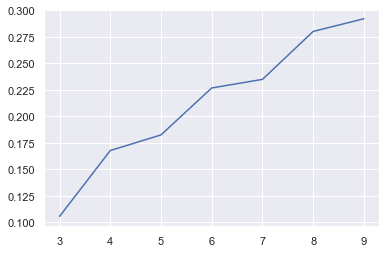

In [96]:
plt.plot(range(3, 10), silhouette)

In [97]:
cls_km = cluster.KMeans(n_clusters=8, n_init=1, max_iter=300, random_state=6)
cls_km.fit(df_ref)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=6, tol=0.0001, verbose=0)

#### 4.3 - [Matrice de confusion](#43)<a class="anchor" id="43"></a>

In [76]:
# Prédiction en fonction du KMeans entraîné sur période de réf (année 2017)
predM0 = cls_km.predict(df_M0)
predM1 = cls_km.predict(df_M1)
predM2 = cls_km.predict(df_M2)
predM3 = cls_km.predict(df_M3)
predM4 = cls_km.predict(df_M4)
predM5 = cls_km.predict(df_M5)
predM6 = cls_km.predict(df_M6)
predM7 = cls_km.predict(df_M7)

In [77]:
# Cluster avec modèle réentrainé.
label_M0 = cls_km.fit(df_M0).labels_
label_M1 = cls_km.fit(df_M1).labels_
label_M2 = cls_km.fit(df_M2).labels_
label_M3 = cls_km.fit(df_M3).labels_
label_M4 = cls_km.fit(df_M4).labels_
label_M5 = cls_km.fit(df_M5).labels_
label_M6 = cls_km.fit(df_M6).labels_
label_M7 = cls_km.fit(df_M7).labels_

In [78]:


def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrixHDB
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

##### 4.3.0 - [Période M+0](#430)<a class="anchor" id="430"></a>

Normalized confusion matrix


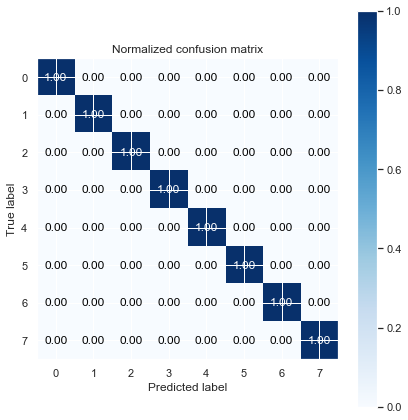

In [79]:
np.set_printoptions(precision=2)
class_names = [0, 1, 2, 3, 4, 5, 6, 7]
plot_confusion_matrix(label_M0, predM0,
                      classes=class_names, normalize=True)
plt.show()

##### 4.3.1 - [Période M+1](#431)<a class="anchor" id="431"></a>

Normalized confusion matrix


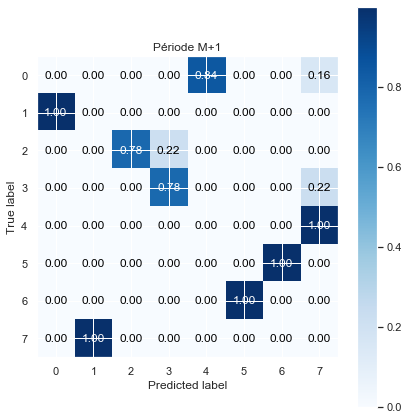

In [80]:
np.set_printoptions(precision=2)
class_names = [0, 1, 2, 3, 4, 5, 6, 7]
plot_confusion_matrix(label_M1, predM1, classes=class_names,
                      normalize=True, title='Période M+1')
plt.show()

##### 4.3.2 - [Période M+2](#432)<a class="anchor" id="432"></a>

Normalized confusion matrix


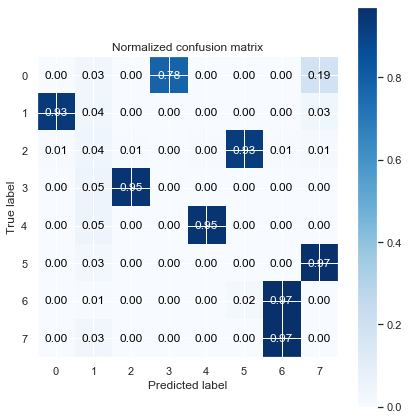

In [81]:
plot_confusion_matrix(label_M2, predM2, classes=class_names,
                      normalize=True)
plt.show()

##### 4.3.3 - [Période M+3](#433)<a class="anchor" id="433"></a>

Normalized confusion matrix


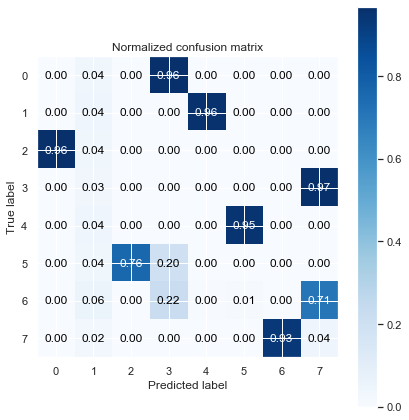

In [82]:
plot_confusion_matrix(label_M3, predM3, classes=class_names,
                      normalize=True)
plt.show()

##### 4.3.4 - [Période M+4](#434)<a class="anchor" id="434"></a>

Normalized confusion matrix


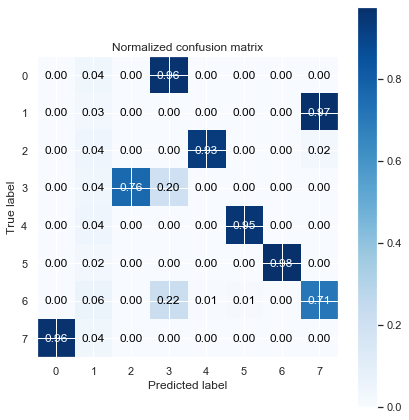

In [83]:
plot_confusion_matrix(label_M4, predM4, classes=class_names,
                      normalize=True)
plt.show()

##### 4.3.5 - [Période M+5](#435)<a class="anchor" id="435"></a>

Normalized confusion matrix


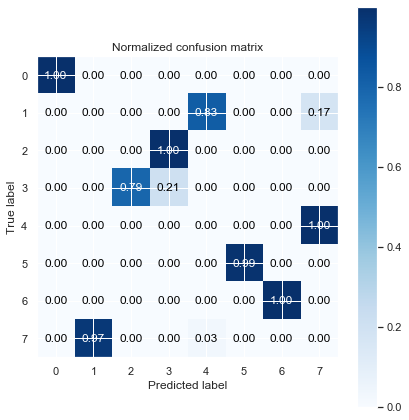

In [84]:
plot_confusion_matrix(label_M5, predM5, classes=class_names,
                      normalize=True)
plt.show()

##### 4.3.6 - [Période M+6](#436)<a class="anchor" id="436"></a>

Normalized confusion matrix


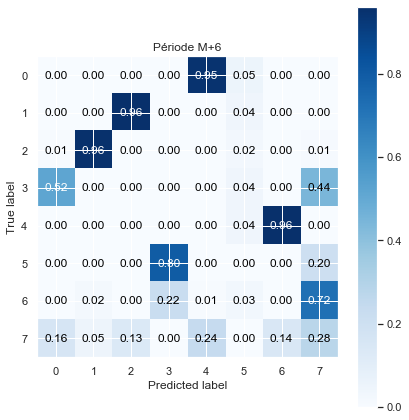

In [85]:
plot_confusion_matrix(label_M6, predM6, classes=class_names,
                      normalize=True, title='Période M+6')
plt.show()

##### 4.3.7 - [Période M+7](#437)<a class="anchor" id="437"></a>

Normalized confusion matrix


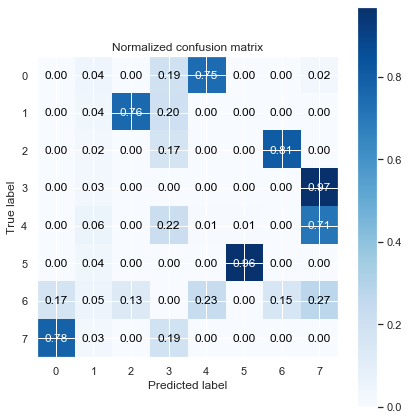

In [86]:
plot_confusion_matrix(label_M7, predM7, classes=class_names,
                      normalize=True)
plt.show()

#### 4.4 - [Evolution de l'indice de Rand ajusté](#44)<a class="anchor" id="44"></a>

In [87]:
preds = [predM1, predM2, predM3, predM4,
         predM5, predM6, predM7]
labels = [label_M1, label_M2, label_M3, label_M4,
          label_M5, label_M6, label_M7]

In [88]:
ARI = []
for p, l in zip(preds, labels):
    ari = adjusted_rand_score(p, l)
    print(ari)
    ARI.append(ari)

0.765550013022041
0.8378199062210336
0.8275621427579531
0.8221937199914974
0.821812136317686
0.7008790717164884
0.6483509991141551


Text(0.5, 0.98, "Evolution de l'ARI")

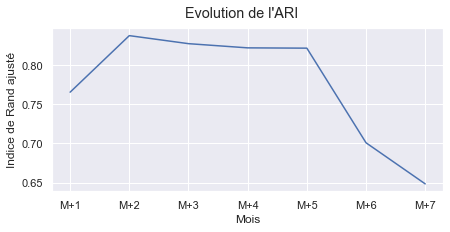

In [89]:
period = ['M+1', 'M+2', 'M+3', 'M+4', 'M+5', 'M+6', 'M+7']

fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(period, ARI)
plt.xlabel("Mois")
plt.ylabel("Indice de Rand ajusté")
fig.suptitle("Evolution de l'ARI")